<a href="https://colab.research.google.com/github/abirm74/Recommendation-System-for-monitoring-RM-issues/blob/abir/PMI_final_version_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
import nltk
nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer
SnowballStemmer.languages
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
!pip install pytesseract
!sudo apt-get install tesseract-ocr
!pip install PyMuPDF
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import pytesseract
from IPython.display import clear_output


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [ ]:
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Extraction

In [ ]:
pmi_corpus = ''
pmi_corpus = open("PMI-1.txt", encoding="utf-8").read()
print(pmi_corpus)

CHAPTER 1
INTRODUCTION

Project Management Institute (PMI) practice standards are guides to the use of a tool, technique, or process
identified in A Guide to the Project Management Body of Knowledge (PMBOK® Guide — Fourth Edition) or
other PMI standards. Practice standards are targeted at audiences who participate in the management of
projects. This includes project managers, project personnel, contract personnel, supervisors, and other project
stakeholders.

 

A PMI practice standard describes processes, activities, inputs, and outputs for a specific Knowledge Area.
It provides information on what the significant process, tool, or technique is, what it does, why it is significant,
when it should be performed or executed, and, if necessary for further clarification, who should perform the
process. A practice standard does not prescribe how the process is to be implemented, leaving that subject for
other forums such as handbooks, manuals, and courses.

This chapter includes the followi

# Figure


In [ ]:
import fitz  # PyMuPDF
import os

def pdf_to_images(pdf_path, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the PDF file
    pdf_document = fitz.open(pdf_path)

    for page_number in range(len(pdf_document)):
        # Get a specific page
        page = pdf_document.load_page(page_number)

        # Convert the page to an image (300 DPI)
        pix = page.get_pixmap(matrix=fitz.Matrix(300/72, 300/72))

        # Save the image as a PNG file
        image_path = f"{output_folder}/page_{page_number + 1}.png"
        pix.save(image_path, "png")

    # Close the PDF file
    pdf_document.close()

# Specify the PDF file path and the output folder
pdf_file_path = "PMI.pdf"
output_folder = "output_images"

# Convert the PDF to images
pdf_to_images(pdf_file_path, output_folder)


In [ ]:
import cv2
import numpy as np

def calculate_min_distance(contour1, contour2):
    min_x_distance = float(10000)
    min_y_distance = float(10000)

    for point1 in contour1:
        for point2 in contour2:
            x1, y1 = point1[0]
            x2, y2 = point2[0]

            x_distance = abs(x1 - x2)
            y_distance = abs(y1 - y2)

            if x_distance < min_x_distance:
                min_x_distance = x_distance

            if y_distance < min_y_distance:
                min_y_distance = y_distance

    return (min_x_distance, min_y_distance)

# Example usage:
#contour1 = np.array([[10, 10], [20, 10], [20, 20], [10, 20]])
#contour2 = np.array([[30, 30], [40, 30], [40, 40], [30, 40]])

# Call the function to calculate the minimal distances
#min_distances = calculate_min_distance(contour1, contour2)
#print(f"Minimal distances: {min_distances}")


In [ ]:
import numpy as np
import networkx as nx

def combine_lists_with_common_elements(elements):
    # Create a graph
    G = nx.Graph()

    # Add nodes and edges to the graph based on common elements
    for i, element_list in enumerate(elements):
        G.add_node(i)  # Add a node for each element_list
        for j in range(i+1, len(elements)):
            for element_i in element_list:
                for element_j in elements[j]:
                    if any(np.array_equal(a, b) for a in element_i for b in element_j):
                        G.add_edge(i, j)
                        break  # No need to check further if a common element is found.

    # Find connected components
    connected_components = list(nx.connected_components(G))

    # Combine lists with common elements
    combined_lists = []
    for component in connected_components:
        combined_list = []
        for index in component:
            combined_list.extend(elements[index])
        combined_lists.append(combined_list)

    return combined_lists

In [ ]:
import cv2
import numpy as np
import pytesseract

import cv2
import numpy as np

def extract_text_outside_contour(image, contour):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create a mask for contour
    x, y, w, h = contour
    mask_contour = np.zeros_like(gray)
    cv2.rectangle(mask_contour, (x, y), (x + w, y + h), 255, thickness=cv2.FILLED)

    # Invert the mask to select the region outside the contour
    mask_outside_contour = 255 - mask_contour

    # Apply the inverted mask to the grayscale image to extract text outside the contour
    text_outside_contour = cv2.bitwise_and(gray, gray, mask=mask_outside_contour)

    # Use Tesseract to extract text from the text_outside_contour
    extracted_text = pytesseract.image_to_string(text_outside_contour)

    # Draw contour in green
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return extracted_text

def create_containing_rectangle(filtered_contours):
    # Find the minimum bounding rectangle that covers the filtered contours
    x, y, w, h = cv2.boundingRect(np.vstack(filtered_contours))
    return x, y, w, h


def extract_charts_bezeyed(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, threshold1=30, threshold2=100)

    # Threshold the image to create a binary image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    min_area = 100
    min_height = 100
    min_width = 100

    # Find contours on the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filtered_contours = []

    for contour in contours:
        # Calculate the bounding rectangle for each contour
        x, y, w, h = cv2.boundingRect(contour)

        # Calculate the area of the contour
        area = cv2.contourArea(contour)

        # Check if the contour meets the filtering criteria
        if area > min_area and h > min_height and w > min_width:
            filtered_contours.append(contour)

    filtered_contours = sorted(filtered_contours, key=lambda contour: cv2.boundingRect(contour)[1])

    haram=[]
    for i in range(len(filtered_contours)):
      wili=[filtered_contours[i]]
      for j in range(i+1,len(filtered_contours)):
        nkhamem = calculate_min_distance(filtered_contours[i], filtered_contours[j])
        if nkhamem[0]<250 and nkhamem[1]<250:
          wili.append(filtered_contours[j])
      haram.append(wili)
    print(len(haram))
    harmano=combine_lists_with_common_elements(haram)
    #print(calculate_min_distance_between_contours(filtered_contours[0],filtered_contours[1]))
    # Create a black background image
    black_background = np.zeros_like(image)

    # Create a black background image
    black_background = np.zeros_like(image)

    extracted_images = []

    for i, ha in enumerate(harmano):
        # Draw the filtered contours on the black background
        cv2.drawContours(black_background, ha, -1, (0, 255, 0), 2)

        # Call the function to create the containing rectangle
        x_old, y_old, w_old, h_old = create_containing_rectangle(ha)
        x =x_old- 300
        y =y_old- 100
        w =w_old+ 600
        h =h_old+ 300

        # Draw the minimum bounding rectangle
        cv2.rectangle(black_background, (x, y), (x + w, y + h), (0, 0, 255), 2)

        # Extract the individual image within the contour
        extracted_image = image[y:y+h, x:x+w].copy()
        #cv2_imshow(extracted_image)
        height, width, _ = extracted_image.shape
        parano=extract_text_outside_contour(extracted_image,[300,100,width-600,height-300])
        #cv2_imshow(extracted_image)
        trik_twil=image[y_old:y_old+h_old, x_old:x_old+w_old].copy()
        extracted_images.append([trik_twil,parano])

    return extracted_images

In [ ]:
def extract_charts(image_path):
    # Load your image
    image = image_path

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image to create a binary image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    min_area=100
    min_height=100
    min_width=100

    # Find contours on the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filtered_contours = []

    for contour in contours:
        # Calculate the bounding rectangle for each contour
        x, y, w, h = cv2.boundingRect(contour)

        # Calculate the area of the contour
        area = cv2.contourArea(contour)

        # Check if the contour meets the filtering criteria
        if area > min_area and h > min_height and w > min_width:
            filtered_contours.append(contour)
    filtered_contours = sorted(filtered_contours, key=lambda contour: cv2.boundingRect(contour)[1])

    haram=[]
    for i in range(len(filtered_contours)):
      wili=[filtered_contours[i]]
      for j in range(i+1,len(filtered_contours)):
        nkhamem = calculate_min_distance(filtered_contours[i], filtered_contours[j])
        if nkhamem[0]<250 and nkhamem[1]<250:
          wili.append(filtered_contours[j])
      haram.append(wili)
    print(len(haram))
    harmano=combine_lists_with_common_elements(haram)
    #print(calculate_min_distance_between_contours(filtered_contours[0],filtered_contours[1]))
    # Create a black background image
    black_background = np.zeros_like(image)

    thnya=[]
    # Draw the filtered contours on the black background
    for ha in harmano:
      cv2.drawContours(black_background, ha, -1, (0, 255, 0), 2)
      # Call the function to create the containing rectangle
      x, y, w, h = create_containing_rectangle(ha)
      cropped_image = image[y:y+h, x:x+w]
      thnya.append(cropped_image)
      #x -= 200
      #y -= 200
      #w += 400
      #h += 400

      # Draw the minimum bounding rectangle
      #cv2.rectangle(black_background, (x, y), (x + w, y + h), (0, 0, 255), 2)
    return thnya

In [ ]:
dhekreyet=[]
for i in range(13,126):
    print("number")
    print(i)
    print("number")
    path='output_images/page_'+str(i)+'.png'
    img=cv2.imread(path)
    l3ib=extract_charts(img)
    for l in l3ib:
        dhekreyet.append(l)
    clear_output(wait=True)

number
125
number
0


In [ ]:
len(dhekreyet)

52

In [ ]:
j=-1
for d in fig_url:
    print('*********************************')
    cv2_imshow(d)

NameError: ignored

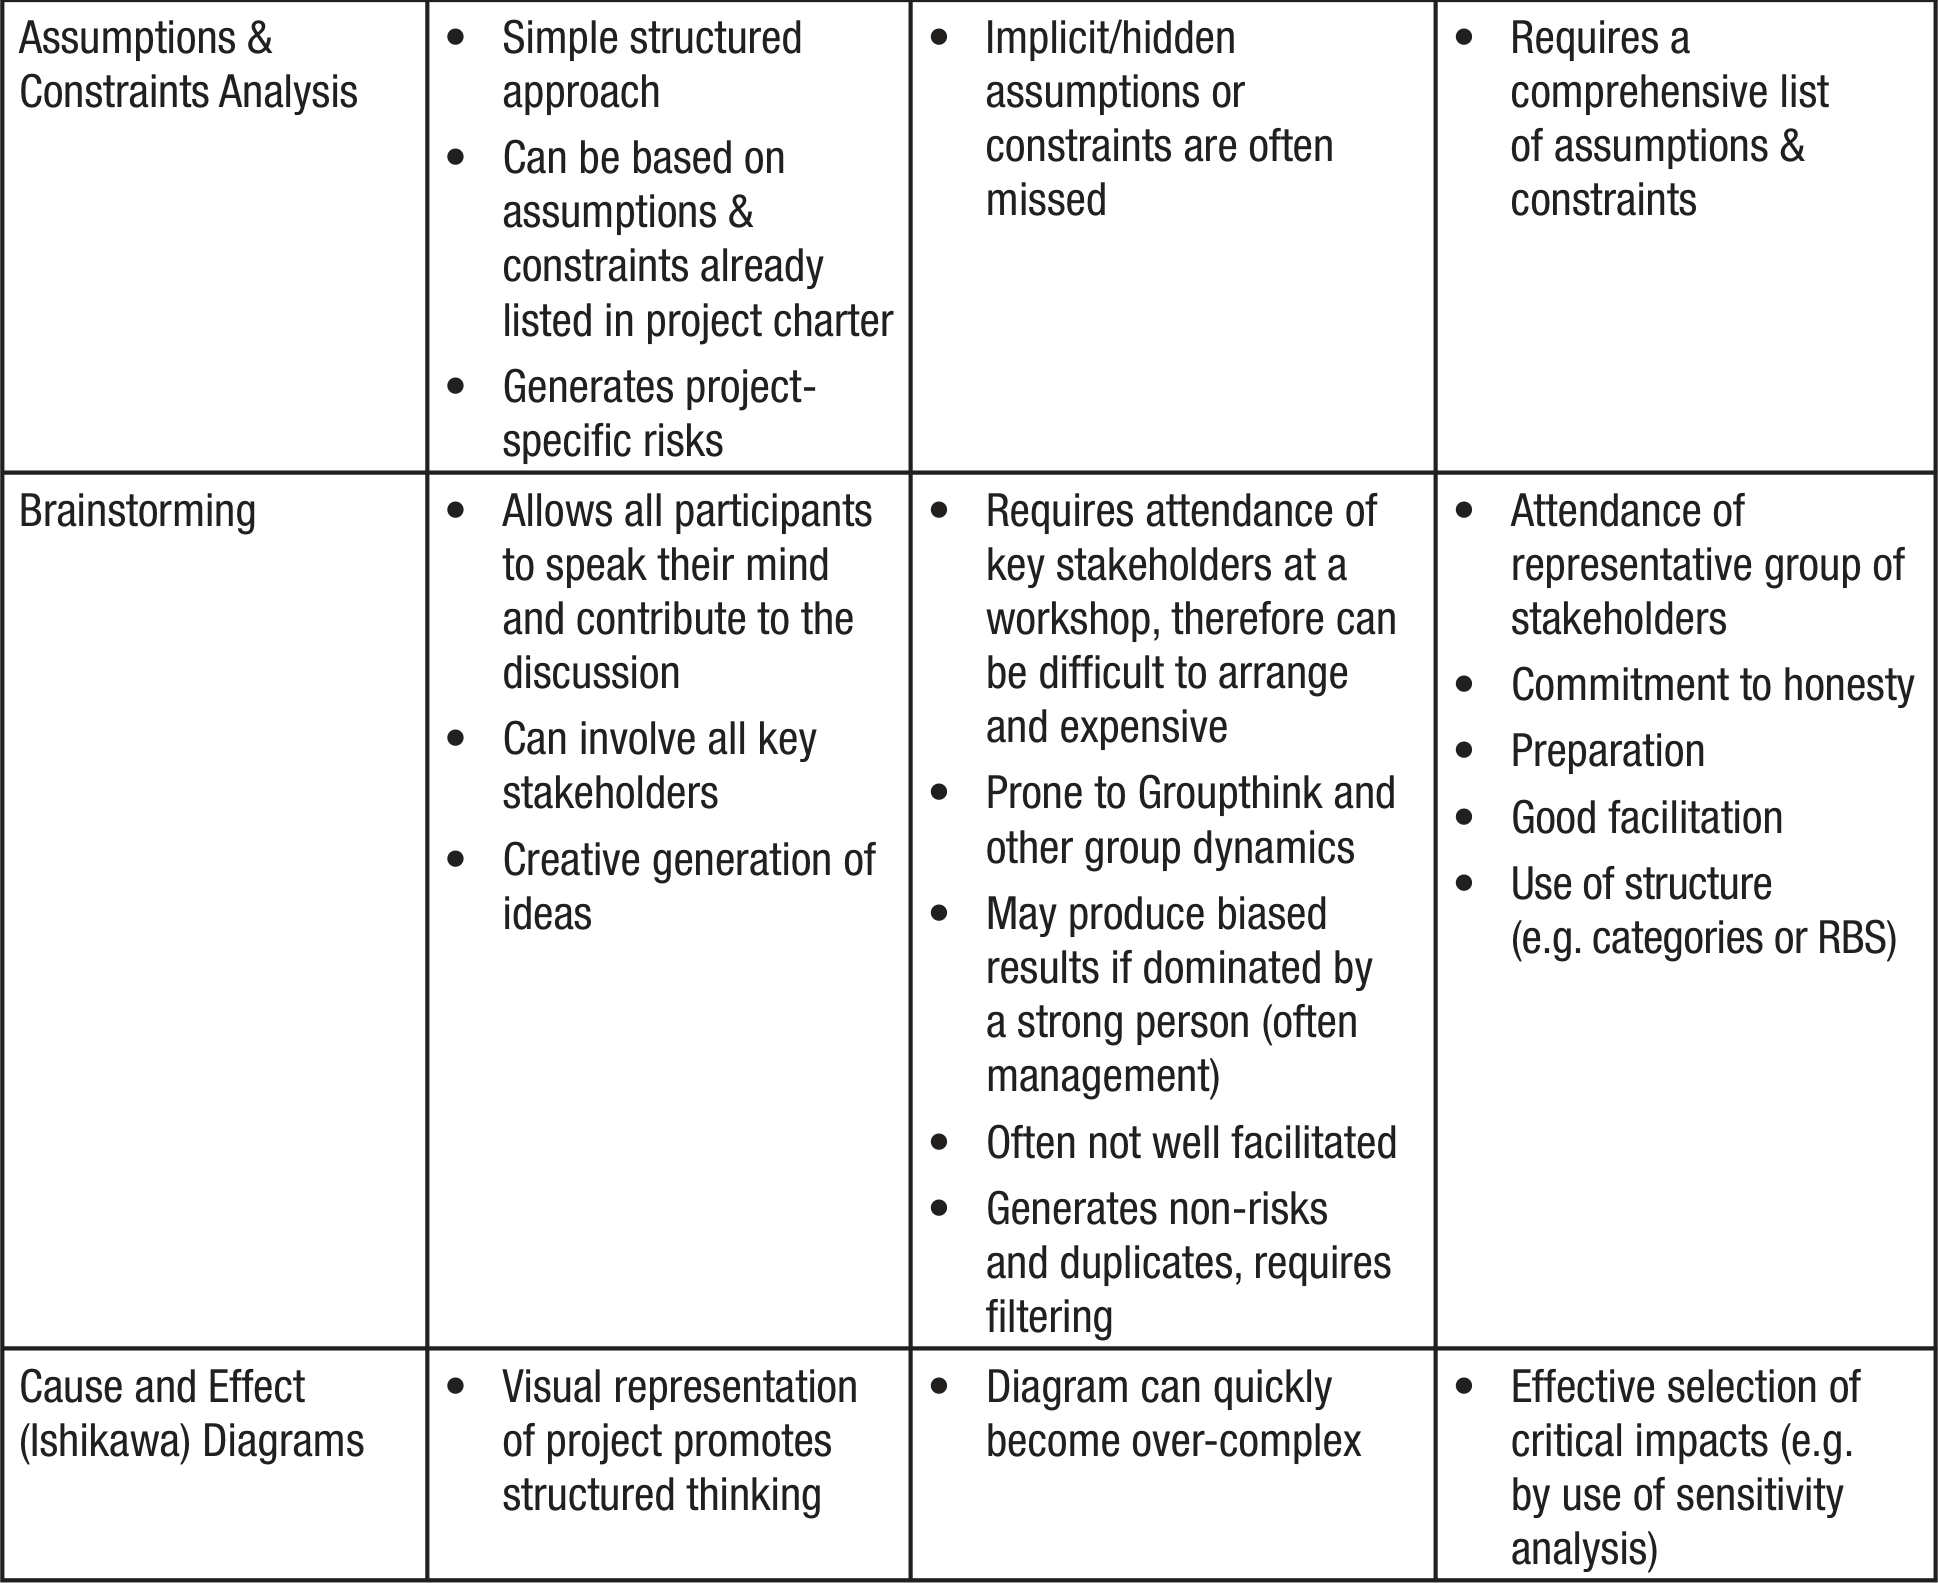

In [ ]:
import cv2

def crop_image_from_top(image, pixels_to_cut):
    # Define the coordinates for the region you want to keep (excluding the top pixels_to_cut pixels)
    x = 0  # X-coordinate of the top-left corner
    y = pixels_to_cut  # Y-coordinate of the top-left corner (skip the top pixels_to_cut pixels)
    width = image.shape[1]  # Width of the region (same as the original image)
    height = image.shape[0] - pixels_to_cut  # Height of the region (excluding the top pixels_to_cut pixels)

    # Crop the image to keep the desired region
    cropped_image = image[y:y+height, x:x+width]

    return cropped_image

# Example usage:
image = dhekreyet[14]  # Replace with your image
pixels_to_cut = 135  # Specify the number of pixels to cut from the top

cropped_image = crop_image_from_top(image, pixels_to_cut)

# Display the cropped image
cv2_imshow( cropped_image)


In [ ]:
crop_image_from_top(dhekreyet[19],135)

array([[[ 72,  70,  70],
        [ 72,  70,  70],
        [ 32,  31,  35],
        ...,
        [ 32,  31,  35],
        [ 32,  31,  35],
        [ 32,  31,  35]],

       [[ 72,  70,  70],
        [ 72,  70,  70],
        [ 32,  31,  35],
        ...,
        [ 32,  31,  35],
        [ 32,  31,  35],
        [ 32,  31,  35]],

       [[ 72,  70,  70],
        [ 72,  70,  70],
        [ 32,  31,  35],
        ...,
        [ 32,  31,  35],
        [ 32,  31,  35],
        [ 32,  31,  35]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

# Cleaning Text

In [ ]:
def clean_text(text):
    text = re.sub(r'^©2009\D.*\n','',text,flags=re.MULTILINE)
    text = re.sub(r'^El\s[^\n]*','',text,flags=re.MULTILINE)
    #text = re.sub(r'(^Figure \d-\d\s[^\n]*\n[^\n]*)|(^Figure \D\d.[^\n]*)','',text,flags=re.MULTILINE)
    text = re.sub(r'^CONTRIBUTORS(\D*.\d\D*){5}(\D*\n\D*.\d\D{348})','',text,flags=re.MULTILINE)
    text = re.sub(r'\(continued\)|^APPENDIX D D>|^APPENDIX D ha|^APPENDIX C|^APPENDIX D ha|^APPENDIX O ha|^El APPENDIX D|^a\) [^\n]*','',text,flags=re.MULTILINE)
    text = re.sub(r'(2009)[^\n]*\n*$','',text,flags=re.MULTILINE)
    text = re.sub(r'(APPENDIX D)\n{2}^Table[^\n]*','',text,flags=re.MULTILINE)
    text = re.sub(r'^e ', '-', text, flags=re.MULTILINE)
    text = re.sub(r'w= ', '', text, flags=re.MULTILINE)
    text = re.sub(r'(^ae[^\n]*)|(^GLOSSARY)', '', text, flags=re.MULTILINE)
    text = re.sub(r'^ay ','',text,flags=re.MULTILINE)
    text = re.sub(r'^Ut ','',text,flags=re.MULTILINE)
    text = re.sub(r'^aT\)|^aT,|^aT\|^o.|^o|^» ','',text,flags=re.MULTILINE)
    text = re.sub(r'^CHAPTER\s1[^\n]+','',text,flags=re.MULTILINE)
    text = text.replace("©.",'')
    text = text.replace("®",'')
    text = text.replace("(a)",'')
    text = text.replace("°°",'')
    text = text.replace("e¢",'')
    text = text.replace("|",'')
    text = text.replace("=",'')
    text = text.replace("—",'')
    text = re.sub(r'{|}|<.*?>', '',text,flags=re.MULTILINE)
    return text
clean = clean_text(pmi_corpus)

In [ ]:
print(clean)

CHAPTER 1
INTRODUCTION

Project Management Institute (PMI) practice standards are guides to the use of a tool, technique, or process
identified in A Guide to the Project Management Body of Knowledge (PMBOK Guide  Fourth Edition) or
ther PMI standards. Practice standards are targeted at audiences who participate in the management of
projects. This includes project managers, project personnel, contract personnel, supervisors, and other project
stakeholders.

 

A PMI practice standard describes processes, activities, inputs, and outputs for a specific Knowledge Area.
It provides information on what the significant process, tool, or technique is, what it does, why it is significant,
when it should be performed or executed, and, if necessary for further clarification, who should perform the
process. A practice standard does not prescribe how the process is to be implemented, leaving that subject for
ther forums such as handbooks, manuals, and courses.

This chapter includes the following s

In [ ]:
first_occurrence_pattern = r'^APPENDIX D\D*'

first_occurrence = re.search(first_occurrence_pattern, clean, flags=re.MULTILINE)
if first_occurrence:

    skip_position = first_occurrence.end()
else:

    skip_position = 0

subsequent_occurrence_pattern = r'^APPENDIX D'
# Remove subsequent occurrences
modified_text = re.sub(subsequent_occurrence_pattern, '', clean[skip_position:], flags=re.MULTILINE)
modified_text = clean[:skip_position] + modified_text

print(modified_text)


CHAPTER 1
INTRODUCTION

Project Management Institute (PMI) practice standards are guides to the use of a tool, technique, or process
identified in A Guide to the Project Management Body of Knowledge (PMBOK Guide  Fourth Edition) or
ther PMI standards. Practice standards are targeted at audiences who participate in the management of
projects. This includes project managers, project personnel, contract personnel, supervisors, and other project
stakeholders.

 

A PMI practice standard describes processes, activities, inputs, and outputs for a specific Knowledge Area.
It provides information on what the significant process, tool, or technique is, what it does, why it is significant,
when it should be performed or executed, and, if necessary for further clarification, who should perform the
process. A practice standard does not prescribe how the process is to be implemented, leaving that subject for
ther forums such as handbooks, manuals, and courses.

This chapter includes the following s

In [ ]:
# Split the text into paragraphs using a blank line as the separator
paragraphs = re.split(r'\n\s*\n', modified_text)
# Clean up and format the paragraphs
formatted_paragraphs = [re.sub(r'\s+', ' ', paragraph.strip()) for paragraph in paragraphs]
# Join the paragraphs into a single string with proper formatting
cleaned_text = '\n\n'.join(formatted_paragraphs)
cleaned_text

'CHAPTER 1 INTRODUCTION\n\nProject Management Institute (PMI) practice standards are guides to the use of a tool, technique, or process identified in A Guide to the Project Management Body of Knowledge (PMBOK Guide Fourth Edition) or ther PMI standards. Practice standards are targeted at audiences who participate in the management of projects. This includes project managers, project personnel, contract personnel, supervisors, and other project stakeholders.\n\nA PMI practice standard describes processes, activities, inputs, and outputs for a specific Knowledge Area. It provides information on what the significant process, tool, or technique is, what it does, why it is significant, when it should be performed or executed, and, if necessary for further clarification, who should perform the process. A practice standard does not prescribe how the process is to be implemented, leaving that subject for ther forums such as handbooks, manuals, and courses.\n\nThis chapter includes the followin

In [ ]:
len(cleaned_text)

162584

# Creating Dataframe

In [ ]:
import re
import pandas as pd

# Using a regular expression to find all matches of section numbers and text
matches = re.finditer(r'((?:[A-Z]?\d+|[A-Z])\.\d+(?:\.\d+)*)\s+(.*?)(?=(?:(?:[A-Z]?\d+|[A-Z])\.\d+(?:\.\d+)*)|$)', cleaned_text, re.DOTALL)

# Create empty lists to store data
sections = []
descriptions = []
figures = []

# Initialize variables to keep track of the current section and its figures
current_section = None
current_description = ""
current_figures = []

# Extract section numbers, text, and figures, and add them to the lists
for match in matches:
    section_number = match.group(1).strip()
    paragraph_text = match.group(2).strip()
    title = paragraph_text.split('\n')[0]

    # Extract figures using a regular expression
    figure_matches = re.findall(r'Figure ([A-Za-z]?\d+-\d+.|[A-Za-z]\d+.)(?=\s|:|$)', paragraph_text)
    figure_names = [f"Figure {fig_name}" for fig_name in figure_matches]

    # Check if the current section has changed
    if current_section != section_number:
        if current_section is not None:
            sections.append(current_section)
            descriptions.append(current_description)
            figures.append(", ".join(current_figures))
        current_section = section_number+ " " +title
        current_description = paragraph_text
        current_figures = figure_names
    else:
        current_description += "\n" + paragraph_text
        current_figures.extend(figure_names)

# Append the last section's data
if current_section:
    sections.append(current_section)
    descriptions.append(current_description)
    figures.append(", ".join(current_figures))

# Create a DataFrame from the data
data = {'Section': sections, 'Description': descriptions, 'Figures': figures}
df = pd.DataFrame(data)
df = df.iloc[5:]

# Reset the index without adding a new index column
df.reset_index(drop=True, inplace=True)
def remove_duplicates_and_preserve_order(figures):
    unique_figures = []
    seen = set()
    for figure in figures.split(', '):
        if figure not in seen:
            seen.add(figure)
            unique_figures.append(figure)
    return ', '.join(unique_figures)
# Apply the function to remove duplicates in the 'Figures' column
df['Figures'] = df['Figures'].apply(remove_duplicates_and_preserve_order)
# Display the resulting DataFrame
df

,Section,Description,Figures
0,1.1 Purpose of the Practice Standard for Proje...,Purpose of the Practice Standard for Project R...,Figure 1-1.
1,1.2 Project Risk Management Definition,Project Risk Management Definition\n\nThe defi...,
2,1.3 Role of Project Risk Management in Project...,Role of Project Risk Management in Project Man...,
3,1.4 Good Risk Management Practice,Good Risk Management Practice\n\nProject Risk ...,
4,1.5 Critical Success Factors for Project Risk ...,Critical Success Factors for Project Risk Mana...,Figure 1-2.
...,...,...,...
174,D.6.1.2 Risk Audits,Risk Audits\n\nRisk audits are carried out in ...,
175,D.6.1.3 Risk Reassessment,Risk Reassessment\n\nThe objective of risk rea...,Figure D20.
176,D.6.1.4 Status Meetings,Status Meetings\n\nRisks can and should be on ...,
177,D.6.1.5 Trend Analysis,Trend Analysis\n\nThe evolution of the varianc...,


In [ ]:
#Exportation CSV
df.to_csv("Dataset.csv", index=False)

# Show example

In [ ]:
df["Figures"][0]

'Figure 1-1.'

In [ ]:
df['Description'] = df['Description'].apply(lambda x: x.lower())
df['Description'].head()

0    purpose of the practice standard for project r...
1    project risk management definition\n\nthe defi...
2    role of project risk management in project man...
3    good risk management practice\n\nproject risk ...
4    critical success factors for project risk mana...
Name: Description, dtype: object

# Most Frequent Words

In [ ]:
from collections import Counter

# Create an empty list to store Counters for each cell
word_counters = []

# Iterate through each text in the "text_wo_stop" column
for text in df["Description"]:
    cnt = Counter()  # Create a Counter for the current cell
    for word in text.split():
        cnt[word] += 1  # Count the words in the current cell
    word_counters.append(cnt)  # Add the Counter to the list

# Now, word_counters contains a list of Counters, one for each cell in the "text_wo_stop" column

# To access the word frequencies in a specific cell (e.g., the first cell):
print(word_counters[0].most_common(10))


[('the', 33), ('and', 26), ('risk', 22), ('of', 16), ('project', 16), ('practice', 15), ('management', 15), ('to', 14), ('standard', 12), ('for', 12)]


In [ ]:
#FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
#def remove_freqwords(text):
#    """custom function to remove the frequent words"""
#    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

#df["Description"] = df["Description"].apply(lambda text: remove_freqwords(text))
#df.head()

,Section,Description,Figures
0,1.1 Purpose of the Practice Standard for Proje...,purpose practice standard purpose practice sta...,Figure 1-1.
1,1.2 Project Risk Management Definition,"definition definition management, defined pmbo...",
2,1.3 Role of Project Risk Management in Project...,role optional activity: essential successful a...,
3,1.4 Good Risk Management Practice,good practice valuable component enhances valu...,
4,1.5 Critical Success Factors for Project Risk ...,critical success factors figure 1-2. critical ...,"Figure 1-2., Figure 1-2."


# Preprocessing

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re

# Define a function to perform preprocessing
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove punctuation and single characters (except single digits)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Tokenization
    words = word_tokenize(text)

    # Sentence Splitting
    sentences = sent_tokenize(text)

    # POS Tagging (including all possible tags)
    pos_tags = pos_tag(words)

    # Stop Words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words and len(word) > 1]  # Removing single characters

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    # Joining words to form a preprocessed text
    preprocessed_text = ' '.join(lemmatized_words)

    return words, sentences, pos_tags, filtered_words, lemmatized_words, preprocessed_text

# Apply the preprocessing function to the 'Description' column and create new columns
df[['words', 'sentences', 'pos_tags', 'filtered_words', 'lemmatized_words', 'preprocessed_text']] = df['Description'].apply(preprocess_text).apply(pd.Series)

# Display the resulting DataFrame with all columns
df


,Section,Description,Figures,words,sentences,pos_tags,filtered_words,lemmatized_words,preprocessed_text
0,1.1 Purpose of the Practice Standard for Proje...,purpose of the practice standard for project r...,Figure 1-1.,"[purpose, of, the, practice, standard, for, pr...",[purpose of the practice standard for project ...,"[(purpose, NN), (of, IN), (the, DT), (practice...","[purpose, practice, standard, project, risk, m...","[purpose, practice, standard, project, risk, m...",purpose practice standard project risk managem...
1,1.2 Project Risk Management Definition,project risk management definition\n\nthe defi...,,"[project, risk, management, definition, the, d...",[project risk management definition\n\nthe def...,"[(project, NN), (risk, NN), (management, NN), ...","[project, risk, management, definition, defini...","[project, risk, management, definition, defini...",project risk management definition definition ...
2,1.3 Role of Project Risk Management in Project...,role of project risk management in project man...,,"[role, of, project, risk, management, in, proj...",[role of project risk management in project ma...,"[(role, NN), (of, IN), (project, NN), (risk, N...","[role, project, risk, management, project, man...","[role, project, risk, management, project, man...",role project risk management project managemen...
3,1.4 Good Risk Management Practice,good risk management practice\n\nproject risk ...,,"[good, risk, management, practice, project, ri...",[good risk management practice\n\nproject risk...,"[(good, JJ), (risk, NN), (management, NN), (pr...","[good, risk, management, practice, project, ri...","[good, risk, management, practice, project, ri...",good risk management practice project risk man...
4,1.5 Critical Success Factors for Project Risk ...,critical success factors for project risk mana...,Figure 1-2.,"[critical, success, factors, for, project, ris...",[critical success factors for project risk man...,"[(critical, JJ), (success, NN), (factors, NNS)...","[critical, success, factors, project, risk, ma...","[critical, success, factor, project, risk, man...",critical success factor project risk managemen...
...,...,...,...,...,...,...,...,...,...
174,D.6.1.2 Risk Audits,risk audits\n\nrisk audits are carried out in ...,,"[risk, audits, risk, audits, are, carried, out...",[risk audits\n\nrisk audits are carried out in...,"[(risk, NN), (audits, NNS), (risk, VBP), (audi...","[risk, audits, risk, audits, carried, order, e...","[risk, audit, risk, audit, carried, order, eva...",risk audit risk audit carried order evaluate r...
175,D.6.1.3 Risk Reassessment,risk reassessment\n\nthe objective of risk rea...,Figure D20.,"[risk, reassessment, the, objective, of, risk,...",[risk reassessment\n\nthe objective of risk re...,"[(risk, NN), (reassessment, VBD), (the, DT), (...","[risk, reassessment, objective, risk, reassess...","[risk, reassessment, objective, risk, reassess...",risk reassessment objective risk reassessment ...
176,D.6.1.4 Status Meetings,status meetings\n\nrisks can and should be on ...,,"[status, meetings, risks, can, and, should, be...",[status meetings\n\nrisks can and should be on...,"[(status, NN), (meetings, NNS), (risks, NNS), ...","[status, meetings, risks, agenda, project, rev...","[status, meeting, risk, agenda, project, revie...",status meeting risk agenda project review typi...
177,D.6.1.5 Trend Analysis,trend analysis\n\nthe evolution of the varianc...,,"[trend, analysis, the, evolution, of, the, var...",[trend analysis\n\nthe evolution of the varian...,"[(trend, NN), (analysis, NN), (the, DT), (evol...","[trend, analysis, evolution, variance, values,...","[trend, analysis, evolution, variance, value, ...",trend analysis evolution variance value time a...


In [ ]:
df['preprocessed_text'][0]

'purpose practice standard project risk management purpose practice standard project risk management provide standard project management practitioner stakeholder defines aspect project risk management recognized good practice project time provide standard globally applicable consistently applied practice standard descriptive purpose rather one used training educational purpose practice standard project risk management cover risk management applied single project like pmbok guide fourth edition practice standard cover risk program portfolio project chapter 11 pmbok guide fourth edition basis practice standard project risk management practice standard consistent chapter emphasizing concept principle relating project risk management aligned pmi practice standard figure 11 compare purpose practice standard pmbok guide fourth edition textbook handbook course figure 11 hierarchy pmi project risk management resource practice standard organized three main section introductory material includin

In [106]:
df['preprocessed_text'][5]

'conclusion principle project risk management described practice standard appropriately applied based specific project organizational environment project risk management provides benefit implemented according good practice principle organizational commitment taking decision performing action open unbiased manner chapter principle concept'

In [99]:
df['lemmatized_words'][1]

['project',
 'risk',
 'management',
 'definition',
 'definition',
 'project',
 'risk',
 'management',
 'defined',
 'pmbok',
 'guide',
 'fourth',
 'edition',
 'basis',
 'practice',
 'standard',
 'project',
 'risk',
 'management',
 'includes',
 'process',
 'concerned',
 'conducting',
 'risk',
 'management',
 'planning',
 'identification',
 'analysis',
 'response',
 'monitoring',
 'control',
 'project',
 'pmbok',
 'guide',
 'fourth',
 'edition',
 'also',
 'state',
 'objective',
 'project',
 'risk',
 'management',
 'increase',
 'probability',
 'impact',
 'positive',
 'event',
 'decrease',
 'probability',
 'impact',
 'negative',
 'event',
 'project',
 'pmbok',
 'guide',
 'fourth',
 'edition',
 'project',
 'risk',
 'uncertain',
 'event',
 'condition',
 'occurs',
 'positive',
 'negative',
 'effect',
 'project',
 'objective',
 'project',
 'objective',
 'include',
 'scope',
 'schedule',
 'cost',
 'quality',
 'project',
 'risk',
 'management',
 'aim',
 'identify',
 'prioritize',
 'risk',
 'advan

# TF-IDF

In [109]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

## Applying TF-IDF on dataframe

In [ ]:
from nltk.text import Text

# Assuming 'df' is your DataFrame with the 'preprocessed_text' column
corpus = Text(df['preprocessed_text'])
corpus


In [110]:
tr_idf_model  = TfidfVectorizer()
tf_idf_vector = tr_idf_model.fit_transform(corpus)


In [112]:
print(type(tf_idf_vector), tf_idf_vector.shape)

<class 'scipy.sparse._csr.csr_matrix'> (179, 2007)


In [113]:
tf_idf_array = tf_idf_vector.toarray()

print(tf_idf_array)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.02002973 0.02002973 0.02002973 ... 0.         0.02002973 0.04005946]]


In [114]:
words_set = tr_idf_model.get_feature_names_out()

print(words_set)

['0113310382' '03175669' '0580331229' ... 'written' 'wycombe' 'zealand']


In [115]:
df_tf_idf = pd.DataFrame(tf_idf_array, columns = words_set)

df_tf_idf

,0113310382,03175669,0580331229,0580390195,0580401,0727733907,0733759041,100,11,12,...,wner,word,work,workassignment,workforce,workshop,would,written,wycombe,zealand
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.109592,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.060771,0.0,0.081945,0.0,0.00000,0.000000
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.149862,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
175,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
176,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
177,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000


In [117]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Get the feature names (terms)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame to store the TF-IDF scores
tfidf_df = pd.DataFrame(data=tfidf_matrix.toarray(), columns=feature_names)

# Display the TF-IDF DataFrame
tfidf_df

,0113310382,03175669,0580331229,0580390195,0580401,0727733907,0733759041,100,11,12,...,wner,word,work,workassignment,workforce,workshop,would,written,wycombe,zealand
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.109592,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.060771,0.0,0.081945,0.0,0.00000,0.000000
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.149862,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
175,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
176,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
177,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000


# Topic Modeling

In [118]:
pip install gensim


In [119]:
from gensim import corpora

# Assuming 'df' is your DataFrame with the 'preprocessed_text' column
documents = df['preprocessed_text']

# Tokenize the documents
tokenized_documents = [doc.split() for doc in documents]

# Create a dictionary from the tokenized documents
dictionary = corpora.Dictionary(tokenized_documents)

# Create a corpus using the dictionary
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]


In [121]:
from gensim.models import LdaModel

# Set the number of topics
num_topics = 9  # You can adjust this based on your needs

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)


In [125]:
# Get the topics and their top terms
topics = lda_model.print_topics(num_topics=num_topics, num_words=10)

for topic in topics:
  print(topic)


(0, '0.097*"risk" + 0.065*"project" + 0.031*"management" + 0.022*"response" + 0.018*"process" + 0.015*"action" + 0.010*"plan" + 0.008*"may" + 0.008*"objective" + 0.006*"owner"')
(1, '0.096*"risk" + 0.051*"project" + 0.025*"analysis" + 0.021*"process" + 0.017*"management" + 0.014*"standard" + 0.013*"quantitative" + 0.013*"practice" + 0.012*"perform" + 0.012*"may"')
(2, '0.034*"risk" + 0.018*"control" + 0.015*"project" + 0.015*"response" + 0.014*"monitor" + 0.013*"objective" + 0.012*"action" + 0.011*"scenario" + 0.008*"plan" + 0.008*"planning"')
(3, '0.025*"decision" + 0.018*"figure" + 0.015*"influence" + 0.015*"diagram" + 0.013*"example" + 0.012*"shown" + 0.010*"simple" + 0.010*"sd" + 0.010*"critical" + 0.009*"analysis"')
(4, '0.083*"risk" + 0.066*"management" + 0.061*"project" + 0.023*"plan" + 0.019*"process" + 0.014*"stakeholder" + 0.008*"level" + 0.008*"activity" + 0.007*"objective" + 0.007*"success"')
(5, '0.026*"risk" + 0.016*"presented" + 0.015*"identification" + 0.014*"project" +

In [126]:
# Get the topic distribution for each document
topic_distributions = [lda_model[doc] for doc in corpus]

# Assign the most probable topic to each document
df['topic'] = [max(td, key=lambda x: x[1])[0] for td in topic_distributions]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


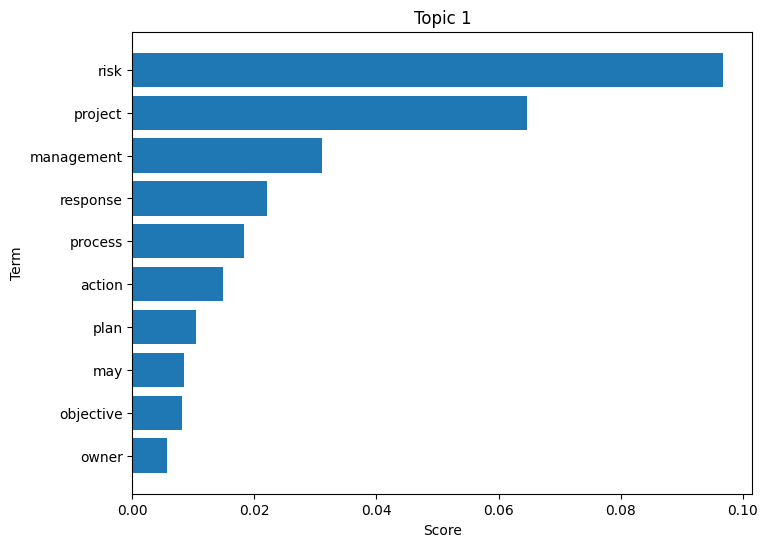

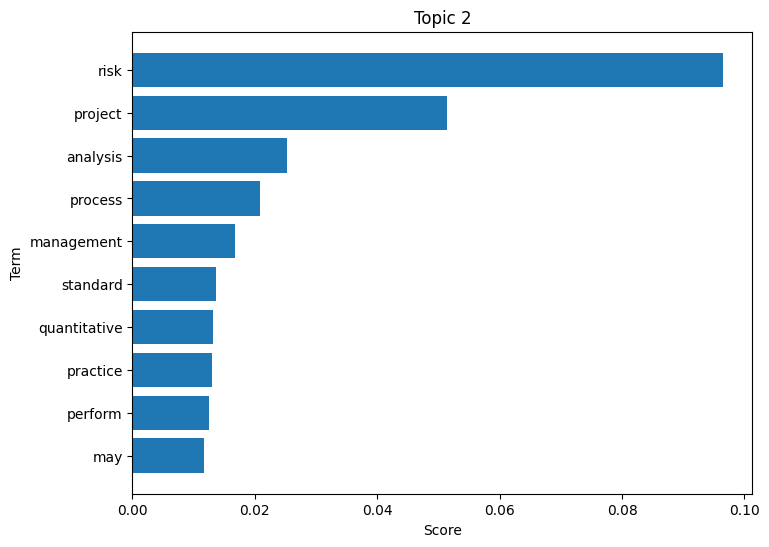

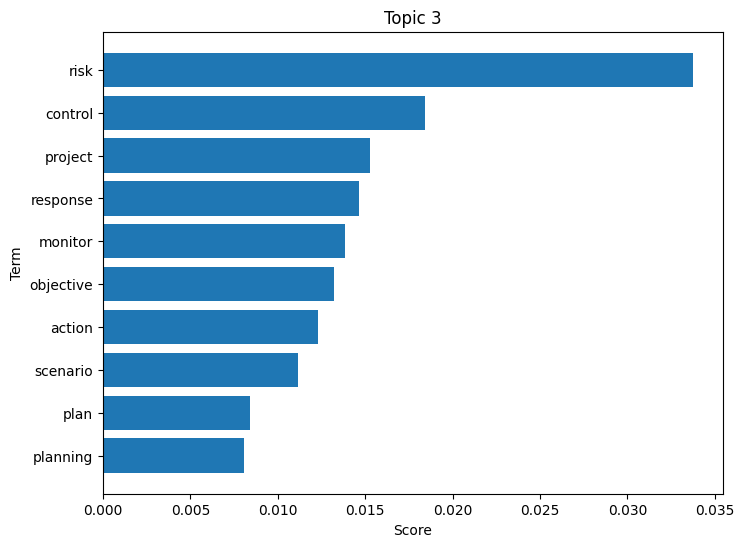

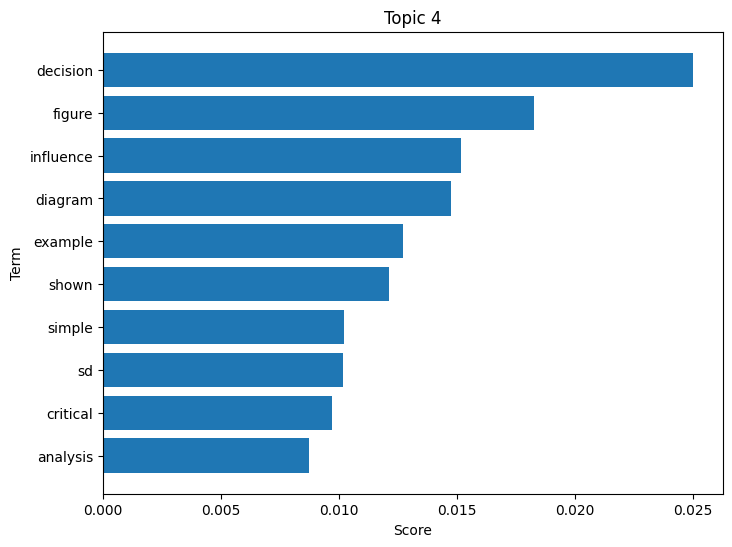

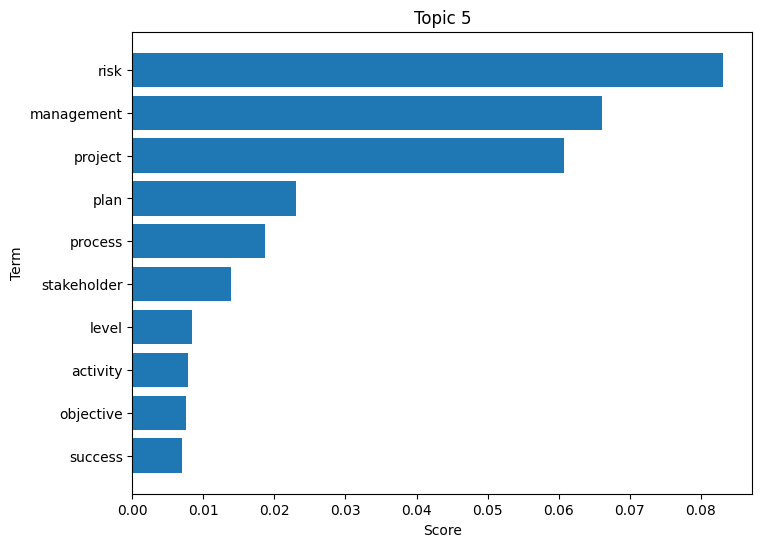

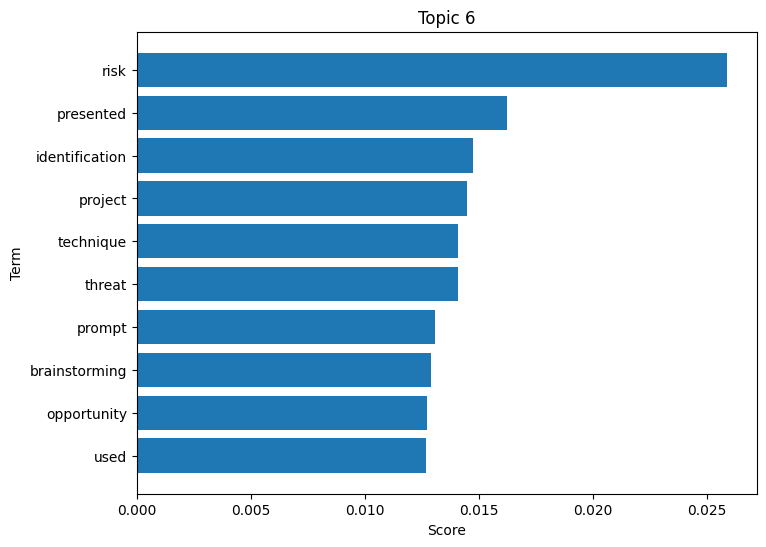

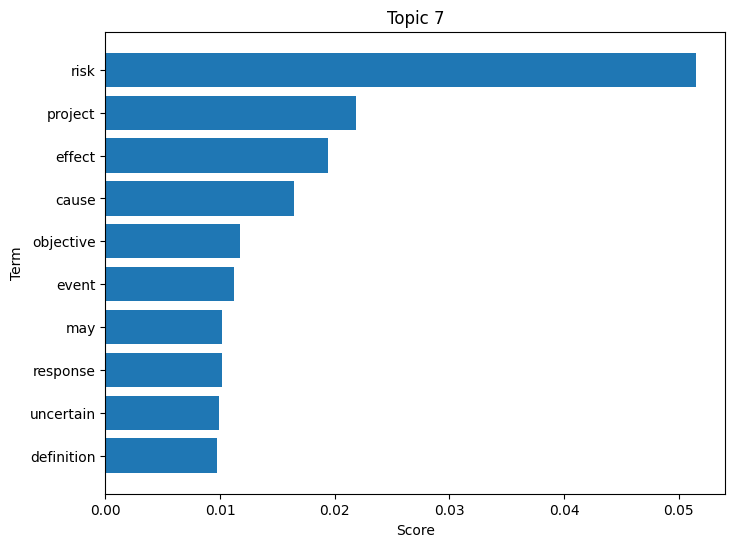

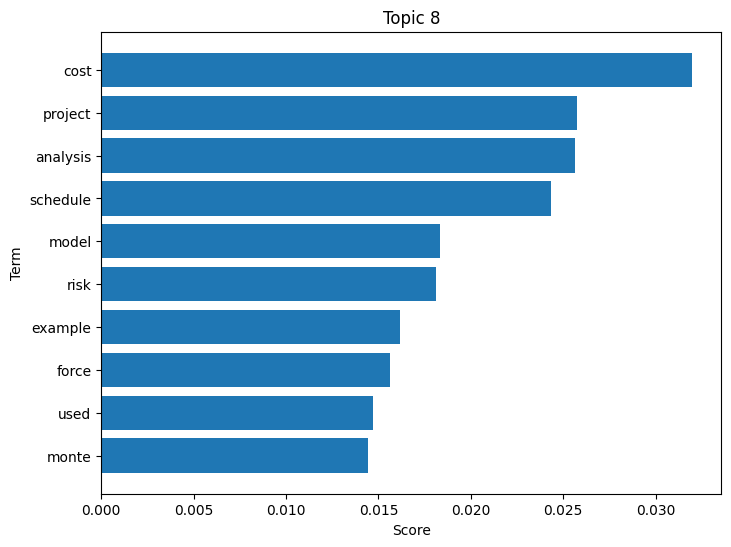

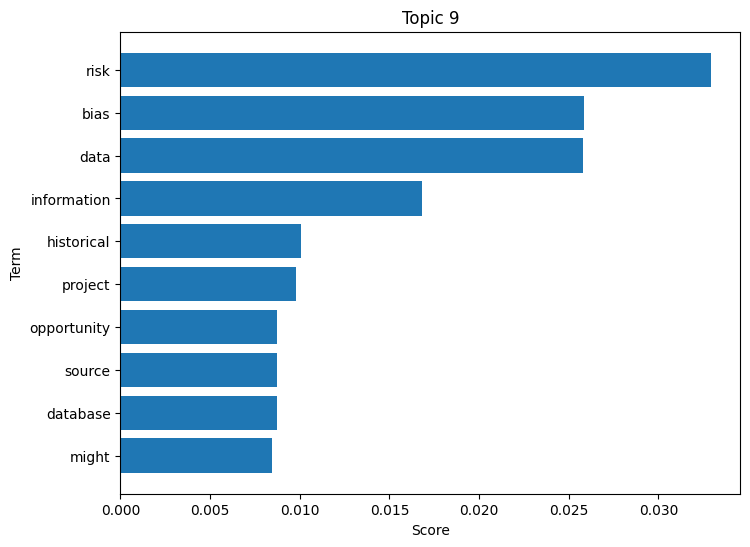

In [129]:
import matplotlib.pyplot as plt

# Assuming you already have 'lda_model' and 'dictionary' from the previous code
topics = lda_model.print_topics(num_topics=num_topics, num_words=10)

# Create a list of topic terms
topic_terms = [lda_model.show_topic(topic, topn=10) for topic in range(num_topics)]

# Plot bar charts for each topic
for topic, terms in enumerate(topic_terms):
    plt.figure(figsize=(8, 6))
    terms, scores = zip(*terms)
    plt.barh(terms, scores)
    plt.title(f'Topic {topic + 1}')
    plt.xlabel('Score')
    plt.ylabel('Term')
    plt.gca().invert_yaxis()
    plt.show()


#Create DF of figures

In [ ]:
fig =dhekreyet
# Your list of matrices
matrices = fig
# Define the indices to be deleted
indices_to_delete = [13, 14, 15, 16, 17, 18, 29, 30, 31, 35, 36, 37, 42, 43, 44, 45, 48, 49, 50]
# Create a new list without the specified indices
fig_url = [matrix for i, matrix in enumerate(matrices) if i not in indices_to_delete]
# filtered_matrices now contains the matrices with the specified indices removed
len(fig_url)

33

In [ ]:
import pandas as pd
from collections import OrderedDict
# Split the column into a list and then flatten it while maintaining the order
split_and_flatten = [item.strip() for sublist in df['Figures'] for item in sublist.split(',')]

# Define the strings to be removed
strings_to_remove = ['','Figure 5-1:']

# Use an OrderedDict to remove duplicates, preserve order, and filter out specific strings
unique_values = [value for value in split_and_flatten if value not in strings_to_remove]
unique_values = list(OrderedDict.fromkeys(unique_values))
len(unique_values)

31

In [ ]:
unique_values = ['Figure 1-1.', 'Figure 1-2.', 'Figure 3-1.', 'Figure 4-1.', 'Figure 5-1.', 'Figure 5-2.','Figure 6-1.',
        'Figure 6-2.', 'Figure 7-1.', 'Figure 7-2.', 'Figure 8-1.', 'Figure 8-2.', 'Figure 9-1.','Figure D1.',
        'Figure D2.', 'Figure D3.', 'Figure D4.', 'Figure D5.', 'Figure D6.', 'Figure D7.', 'Figure D8.',
        'Figure D9.', 'Figure D11.', 'Figure D10.', 'Figure D12.', 'Figure D13.', 'Figure D14.',
        'Figure D15.', 'Figure D16.', 'Figure D17.', 'Figure D18.', 'Figure D19.', 'Figure D20.']
df_fig = pd.DataFrame({'Figures': unique_values, 'fig_url': fig_url})
# Si vous souhaitez conserver l'ordre d'origine, vous pouvez ajouter un index
df_fig.index = list(range(len(df_fig)))
df_fig

,Figures,fig_url
0,Figure 1-1.,"[[[32, 31, 35], [32, 31, 35], [32, 31, 35], [3..."
1,Figure 1-2.,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,Figure 3-1.,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,Figure 4-1.,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,Figure 5-1.,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
5,Figure 5-2.,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
6,Figure 6-1.,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
7,Figure 6-2.,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
8,Figure 7-1.,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
9,Figure 7-2.,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [ ]:

# Concatenate based on matching values in column 'B'
result = df_fig.merge(df, on='Figures', how='right')

In [ ]:
result

,Figures,fig_url,Section,Description
0,Figure 1-1.,"[[[32, 31, 35], [32, 31, 35], [32, 31, 35], [3...",1.1 Purpose of the Practice Standard for Proje...,purpose of the practice standard for project r...
1,,NaN,1.2 Project Risk Management Definition,project risk management definition\n\nthe defi...
2,,NaN,1.3 Role of Project Risk Management in Project...,role of project risk management in project man...
3,,NaN,1.4 Good Risk Management Practice,good risk management practice\n\nproject risk ...
4,Figure 1-2.,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1.5 Critical Success Factors for Project Risk ...,critical success factors for project risk mana...
...,...,...,...,...
174,,NaN,D.6.1.2 Risk Audits,risk audits\n\nrisk audits are carried out in ...
175,Figure D20.,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",D.6.1.3 Risk Reassessment,risk reassessment\n\nthe objective of risk rea...
176,,NaN,D.6.1.4 Status Meetings,status meetings\n\nrisks can and should be on ...
177,,NaN,D.6.1.5 Trend Analysis,trend analysis\n\nthe evolution of the varianc...
